In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import seqlogo
from IPython.display import clear_output
import datetime
from scipy.stats import spearmanr
import csv
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

False

In [2]:
# Load DMR mCG levels
dmrs_mc = pd.read_csv('/cndd/emukamel/CNN_DMR/data_INTACT/Mouse_DMRs_methylation_level.csv',
                  names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)

ndmrs, ncelltypes = dmrs_mc.shape
print(ndmrs, ncelltypes)

58959 15


In [3]:
dmrs_mcu = dmrs_mc.numpy()
dmrs_mc_mean = dmrs_mc.mean(axis=1)
# plt.plot(np.mean(dmrs_mcu,axis=1), np.std(dmrs_mcu,axis=1),'.')
# dmrs_mcu[0:5,:]
np.mean(dmrs_mcu,axis=1).shape
dmrs_mc_mean.shape

torch.Size([58959])

In [4]:
# Load Kmers
K = 5;
fn_kmer = '/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K'+str(K)+'_counts.csv'
kmers = pd.read_csv(fn_kmer, header=None)
nkmers = kmers.shape[1]
kmers = torch.tensor(kmers.to_numpy(), dtype=torch.int)
print(kmers.shape)

torch.Size([58959, 512])


In [5]:
# Define the neural net architecture
n1 = 256;

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear( nkmers, n1)
        self.fc3 = nn.Linear( n1, ncelltypes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device is not "cpu":
    net.to(torch.device(device))
# criterion = nn.MSELoss()
# penalty = nn.L1Loss()
mseloss=nn.MSELoss()

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=lr)

batch_size=20
if device is not "cpu":
    net.to(device)
net.train
running_time = 0
loss_vec = corr_vec = []
nepochs = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [7]:
out_fn='KmerRegression_K%d_TorchTrained_%s.lr%3.3f.save' % (K, datetime.datetime.now().strftime('%m-%d-%y'),lr)
print(out_fn)

loss_test=np.array([])
loss_train = np.array([])
nparams = np.array([])
l1params = np.array([])

KmerRegression_K5_TorchTrained_12-01-19.lr0.010.save


In [8]:
# out_fn='CNN_trained_11-19-19.seqsize600.lr0.010.save'
checkpoint = torch.load(out_fn)
print(checkpoint.keys())
net.load_state_dict(checkpoint['net_state'])
loss_train = np.array(checkpoint['loss_train'])
loss_test = np.array(checkpoint['loss_test'])
len(loss_test)

dict_keys(['net_state', 'loss_train', 'loss_test'])


78

In [9]:
dmrs_mc_mean = torch.mean(dmrs_mc, dim=1).reshape([-1,1])
# dmrs_mcu = dmrs_mc - dmrs_mc_mean
dmrs_mcu = dmrs_mc 
dmrs_mc_mean.shape

torch.Size([58959, 1])

In [10]:
l1_alpha = 0/nkmers;

lr = 0.001
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

def criterion(y,yhat,weights):
    loss = nn.MSELoss()(y,yhat) + l1_alpha*torch.norm(weights,1)
    return loss

def Numparams(weights):
    l1 = torch.sum(torch.abs(weights))
    nparms = torch.sum(torch.abs(weights)>0)
    
    return nparms.cpu().detach(), l1.cpu().detach()

# X = torch.transpose(seqs_1hot_tensor.float(),2,1).float()
trainfrac = 0.8
num_epochs = 100
batch_size=64

torch.manual_seed(0)
permutation = torch.randperm(ndmrs)
ntrain = round(ndmrs*trainfrac)

training = permutation[:ntrain]
testing = permutation[ntrain:(ntrain+1000)]

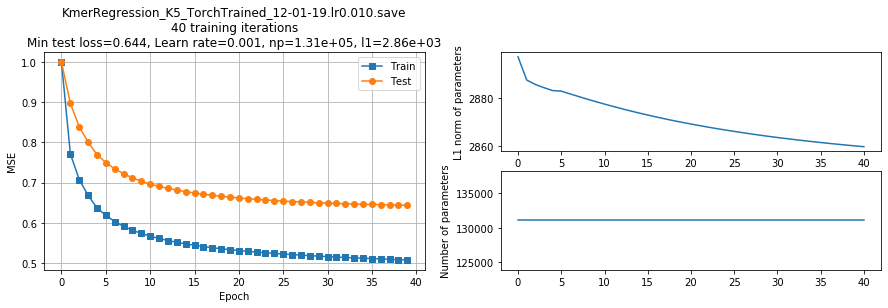

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_time = 0

    np_curr, l1 = Numparams(net.fc1.weight)
    nparams = np.append(nparams,np_curr)
    l1params = np.append(l1params,l1)
    
    start=time.time()
    nsamp=0
    running_loss = 0.0
    net.train()
    for i in range(0, len(training), batch_size):
        indices = training[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = kmers[indices,:].float()
        batch_dmrs_mc = dmrs_mcu[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc, net.fc1.weight)
        loss.backward()
        optimizer.step()

#         print('Train: i=%d, loss=%g' % (i, loss.item()))
        running_loss += mseloss(outputs, batch_dmrs_mc).item()
        nsamp += 1
        if (time.time()-start)>5:
            # print statistics
            running_time += time.time()-start
            print('  [Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
                  (batch_size, len(loss_test), i, len(training), 100*i/len(training), running_loss/nsamp, 1000*running_time/i))
            start = time.time()
    loss_train = np.append(loss_train,running_loss/nsamp)
            
    # Test/Validate
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    for i in range(0, len(testing), batch_size):
        indices = testing[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = kmers[indices,:].float()
        batch_dmrs_mc = dmrs_mcu[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # forward + backward + optimize
        outputs = net(batch_X)

        running_loss_test += mseloss(outputs, batch_dmrs_mc).item()
        nsamp += 1
    loss_test = np.append(loss_test,running_loss_test/nsamp)

    print('*** Epoch %d/%d, %d total training epochs, loss for train: %3.6g, test: %3.6g, time=%3.3f s' %
          (len(loss_test), num_epochs, len(loss_train), loss_train[-1], loss_test[-1], running_time))

    torch.save({
        'net_state': net.state_dict(),
        'loss_train': loss_train,
        'loss_test': loss_test,
    }, out_fn)
    print('Saved %s' % out_fn)
    
    scheduler.step(running_loss_test/nsamp)
    
    ##
    if len(loss_train)>1:
        clear_output()
        plt.figure(figsize=(15,4))
        plt.subplot(1,2,1)
        plt.plot(loss_train/loss_train[0],'s-')
        plt.plot(loss_test/loss_test[0],'o-')
        plt.legend(['Train','Test'])
        plt.title('%s\n%d training iterations\nMin test loss=%3.3g, Learn rate=%3.3g, np=%3.3g, l1=%3.3g' % 
                  (out_fn, len(loss_train), np.min(loss_test/loss_test[0]), optimizer.param_groups[0]['lr'],
                  np_curr, l1))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        # plt.xlim([0,80]);
        
        plt.subplot(2,2,2)
        plt.plot(l1params)
        plt.ylabel('L1 norm of parameters')
        plt.subplot(2,2,4)
        plt.plot(nparams)
        plt.ylabel('Number of parameters')
        
        plt.show()
print('Finished Training')

Text(0, 0.5, 'Number of parameters')

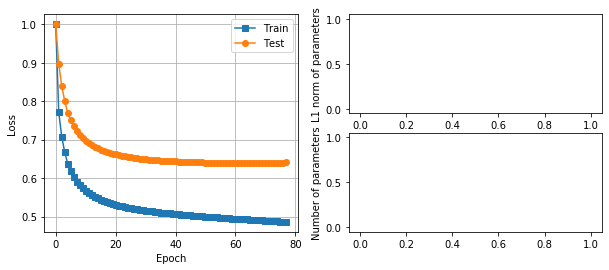

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_train/loss_train[0],'s-')
plt.plot(loss_test/loss_test[0],'o-')
plt.legend(['Train','Test'])
# plt.title('%s\n%d training iterations\nMin test loss=%3.3g, Learn rate=%3.3g, np=%3.3g, l1=%3.3g' % 
#           (out_fn, len(loss_train), np.min(loss_test/loss_test[0]), optimizer.param_groups[0]['lr'],
#           np_curr, l1))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim([0,80]);

plt.subplot(2,2,2)
plt.plot(l1params)
plt.ylabel('L1 norm of parameters')
plt.subplot(2,2,4)
plt.plot(nparams)
plt.ylabel('Number of parameters')


In [12]:
# Test/Validate
net.eval()
dmrs_mc_hat = np.zeros(dmrs_mc.shape)
for i in range(0, len(testing), batch_size):
    indices = testing[i:i+batch_size]

    # Input should be of size: (batch, channels, samples)
    batch_X = kmers[indices,:].float()
    batch_dmrs_mc = dmrs_mcu[indices]

    # Send training data to CUDA
    if device is not "cpu":
        batch_X = batch_X.to(device)
        batch_dmrs_mc = batch_dmrs_mc.to(device)

    # forward + backward + optimize
    outputs = net(batch_X)
    dmrs_mc_hat[indices,:] = outputs.cpu().detach().numpy()


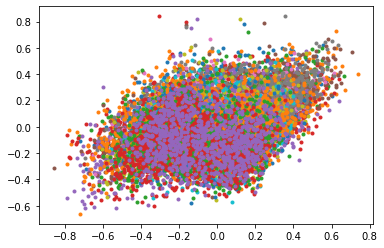

In [13]:
y = dmrs_mc[testing,:]-dmrs_mc_mean[testing]
yhat = dmrs_mc_hat[testing,:]-dmrs_mc_mean[testing].numpy()
plt.plot(y, yhat, '.');

r = 0.207 (-0.035-0.511)


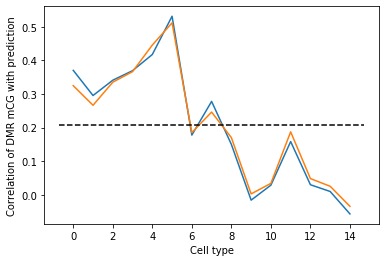

In [14]:
r = [np.corrcoef(y[:,i],yhat[:,i])[0,1] for i in range(ncelltypes)]
r_spearman = [spearmanr(y[:,i],yhat[:,i]).correlation for i in range(ncelltypes)]
R2 = [1-r**2 for r in r]
# plt.plot(R2)
# plt.plot(plt.xlim(),[np.mean(R2)]*2,'k--')
plt.plot(r_spearman)
plt.plot(r)
plt.plot(plt.xlim(),[np.mean(r)]*2,'k--')
plt.xlabel('Cell type')
plt.ylabel('Correlation of DMR mCG with prediction')
plt.title('r = %3.3f (%3.3f-%3.3f)' % (np.mean(r), np.min(r), np.max(r)))

ValueError: num must be 1 <= num <= 8, not 9

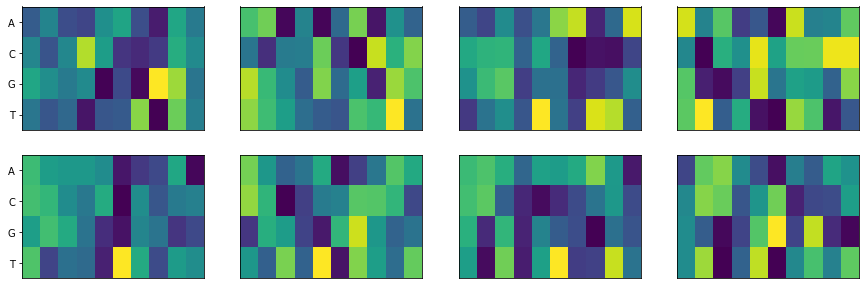

In [34]:
# Visualize the weight matrices
weights = net.state_dict()['conv1.weight'].cpu().numpy()
plt.figure(figsize=(ncelltypes,2*nfilt/4))
for jfeature in range(weights.shape[0]):
    plt.subplot(nfilt/4,4,jfeature+1,xmargin=-0.4)
    weight = weights[jfeature,:,:].squeeze()
#     plt.imshow(weight, aspect='auto', vmin=-.1,vmax=.1)
    plt.imshow(weight, aspect='auto')
    plt.xticks([])
    if (jfeature % 4 ==0):
        plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
    else:
        plt.yticks([])
#     if jfeature>5:
#         break

plt.subplots_adjust(wspace=0.05)
plt.colorbar();
# plt.show()